In [2]:
using DrWatson
findproject(@__DIR__) |> quickactivate

using SpikingNeuralNetworks
using UnPack
using Logging
using Plots

global_logger(ConsoleLogger())
SNN.@load_units

0.001f0

In [4]:
import SpikingNeuralNetworks: IF, IFSinExpParameter, PoissonLayerParameter, PoissonLayer, SpikingSynapse

Zerlaut2019_network = (Npop = (E=4000, I=1000),
    exc = IFSinExpParameter(
                τm = 200pF / 10nS, 
                El = -70mV, 
                Vt = -50.0mV, 
                Vr = -70.0f0mV,
                R  = 1/10nS, 
                τabs = 2ms,       
                τi=5ms,
                τe=5ms,
                E_i = -80mV,
                E_e = 0mV,
                ),

    inh = IFSinExpParameter(
                τm = 200pF / 10nS, 
                El = -70mV, 
                Vt = -53.0mV, 
                Vr = -70.0f0mV,
                R  = 1/10nS, 
                τabs = 2ms,       
                τi=5ms,
                τe=5ms,
                E_i = -80mV,
                E_e = 0mV,
                ),

    connections = (
        E_to_E = (p = 0.05, μ = 2nS),
        E_to_I = (p = 0.05, μ = 2nS),
        I_to_E = (p = 0.05, μ = 10nS),
        I_to_I = (p = 0.05, μ = 10nS),
        ),
    
    afferents = (
        N = 100,
        p = 0.1f0,
        rate = 20Hz,
        μ = 4.0,
        ), 
)

function network(config)
    @unpack afferents, connections, Npop = config
    E = IF(N=Npop.E, param=config.exc, name="E")
    I = IF(N=Npop.I, param=config.inh, name="I")

    AfferentParam = PoissonLayerParameter(afferents.rate; afferents...)
    afferentE = PoissonLayer(E, :ge, param=AfferentParam, name="noiseE")
    afferentI = PoissonLayer(I, :ge, param=AfferentParam, name="noiseI")

    synapses = (
        E_to_E = SpikingSynapse(E, E, :ge, p=connections.E_to_E.p, μ=connections.E_to_E.μ, name="E_to_E"),
        E_to_I = SpikingSynapse(E, I, :ge, p=connections.E_to_I.p, μ=connections.E_to_I.μ, name="E_to_I"),
        I_to_E = SpikingSynapse(I, E, :gi, p=connections.I_to_E.p, μ=connections.I_to_E.μ, name="I_to_E"),
        I_to_I = SpikingSynapse(I, I, :gi, p=connections.I_to_I.p, μ=connections.I_to_I.μ, name="I_to_I"),
    )
    model = SNN.compose(;E,I, afferentE, afferentI, synapses..., silent=true, name="Balanced network") 
    SNN.monitor!(model.pop, [:fire])
    SNN.monitor!(model.stim, [:fire])
    # monitor!(model.pop, [:v], sr=200Hz)
    return SNN.compose(;model..., silent=true)
end

network (generic function with 1 method)

In [5]:
model = network(Zerlaut2019_network) 
SNN.print_model(model)
SNN.sim!(model, duration=5s)

[ Info: ================
[ Info: Model: Balanced network
[ Info: Time: 0.0 s
[ Info: ----------------
[ Info: Populations (2):
[ Info: E         : IF        :  4000       IFSinExpPa
[ Info: I         : IF        :  1000       IFSinExpPa
[ Info: ----------------
[ Info: Synapses (4): 
[ Info: E_to_E             : E -> E.ge                     :           : NoLTP      : NoSTP     
[ Info: E_to_I             : E -> I.ge                     :           : NoLTP      : NoSTP     
[ Info: I_to_E             : I -> E.gi                     :           : NoLTP      : NoSTP     
[ Info: I_to_I             : I -> I.gi                     :           : NoLTP      : NoSTP     
[ Info: ----------------
[ Info: Stimuli (2):
[ Info: noiseE     : noiseE -> E.ge                 PoissonStimulus
[ Info: noiseI     : noiseI -> I.ge                 PoissonStimulus
[ Info: ================


5000.0f0

┌ Warning: Subsampling raster plot, 1 out of 3 spikes
└ @ SNNModels ~/.julia/packages/SNNModels/6KeZt/src/analysis/spikes.jl:735


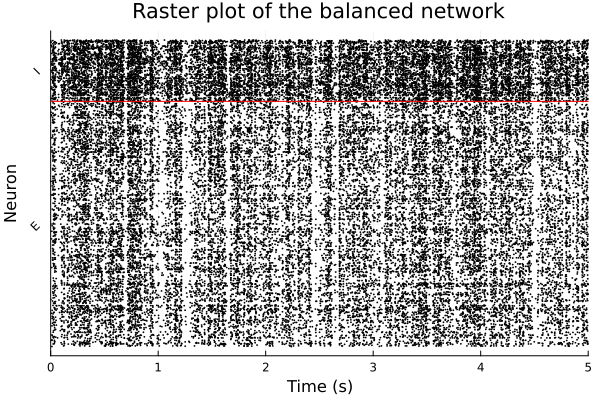

In [6]:
SNN.raster(model.pop, every=5, title="Raster plot of the balanced network")

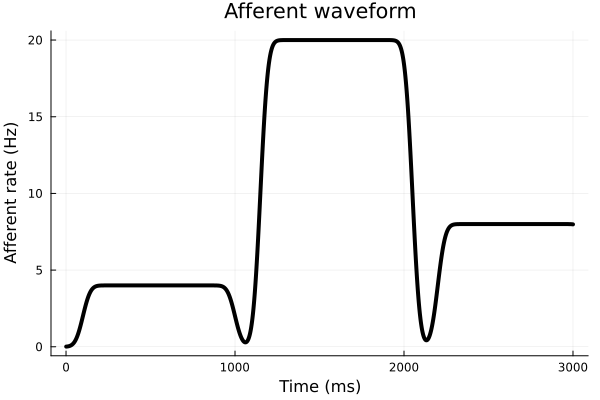

In [8]:
wave = (
    Faff1= 4.,
    Faff2= 20,
    Faff3 =8.,
    DT= 900.,
    rise =50.
)
using SpecialFunctions
waveform = zeros(3000)
t = 1:3000
for (tt, fa) in zip(2 .*wave.rise .+(0:2) .*(3 .*wave.rise + wave.DT), [wave.Faff1, wave.Faff2, wave.Faff3])
    waveform .+= fa .* (1 .+erf.((t .-tt) ./wave.rise)) .* (1 .+erf.(-(t.-tt.-wave.DT)./wave.rise))./4
end

plot(waveform, xlabel="Time (ms)", ylabel="Afferent rate (Hz)", title="Afferent waveform", legend=false, lw=4, c=:black)

Run simulation with varying input

In [9]:
SNN.reset_time!(model)
SNN.clear_records!(model)
SNN.monitor!(model.pop, [:v])
for t in 1:3000
    model.stim.afferentE.param.rates .= waveform[t] .*Hz
    model.stim.afferentI.param.rates .= waveform[t] .*Hz
    SNN.sim!(model, duration=1ms)
end

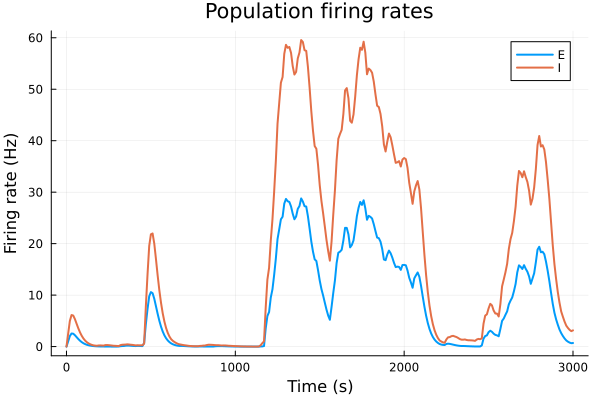

In [10]:
fr, r, labels = SNN.firing_rate(model.pop, interval=0f0:10ms:3s, pop_average=true);
plot(r, fr, labels=hcat(labels...), xlabel="Time (s)", ylabel="Firing rate (Hz)", title="Population firing rates", lw=2)

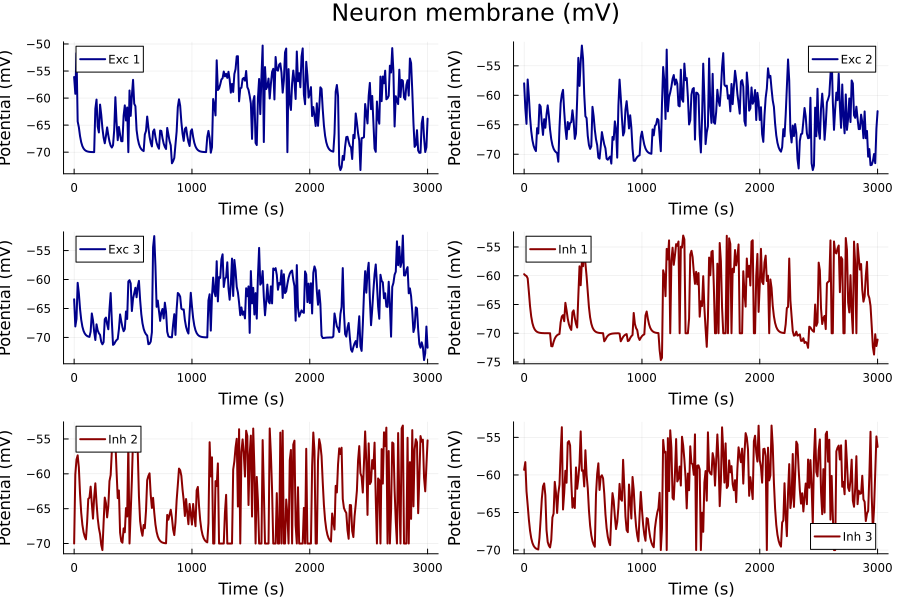

In [11]:
v , r = SNN.record(model.pop.E, :v, interval=0f0:10ms:3s, range=true);
plotsE = map(1:3) do i
    plot(r, v[i,:], xlabel="Time (s)", ylabel="Potential (mV)", label="Exc $i",  lw=2, c=:darkblue)
end
v , r = SNN.record(model.pop.I, :v, interval=0f0:10ms:3s, range=true);
plotsI = map(1:3) do i
    plot(r, v[i,:], xlabel="Time (s)", ylabel="Potential (mV)", label="Inh $i",  lw=2, c=:darkred)
end
plots = vcat(plotsE..., plotsI...)
plot(plots..., layout=(3,2), plot_title="Neuron membrane (mV)", size=(900,600))